In [1]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
import pickle
import math
import os

#IMPORTS FOR MODELLING
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Activation, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras import optimizers, metrics, losses
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import tensorflow_addons as tfa;

c:\Users\gbolton\OneDrive\Thesis\.venv2\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [60]:
def encode(df, one_hot_cols, base_n_encoder_cols):
    df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True, dtype=int)
    encoder = ce.BaseNEncoder(cols=base_n_encoder_cols, return_df=True, base=2)
    df = encoder.fit_transform(df)

    return df

In [61]:
def scale(df, numeric_cols):
    scaler = RobustScaler()
    values = df[numeric_cols].values
    scaled_values = scaler.fit_transform(values)
    df.loc[:,numeric_cols] = np.array(scaled_values)

    return df

In [62]:
def encode_scale_split(df, train, validate, numeric_cols, one_hot_cols, base_n_encoder_cols):
    """encode scale and split dataset"""
    #ENCODE
    df = encode(df, one_hot_cols, base_n_encoder_cols)
    df = df.sort_values(by = ["date copy"], axis = 0, ascending = True)
    train_indice = int(train * len(df))
    validate_indice = train_indice + int(validate * len(df))
    df = df.drop(columns = ["date copy"])

    train_set = df.iloc[:train_indice]
    val_set = df.iloc[train_indice:validate_indice]
    test_set = df.iloc[validate_indice:]
    
    #PERFORM SCALING
    train_set = scale(train_set, numeric_cols)
    val_set = scale(val_set, numeric_cols)
    test_set = scale(test_set, numeric_cols)
    
    #SPLIT THE DATASET
    target_col = "AWARD_VALUE_EURO_FIN_1"
    X_train = train_set.drop(columns = [target_col]).values
    y_train = train_set[target_col].values

    X_val = val_set.drop(columns = [target_col]).values
    y_val = val_set[target_col].values

    X_test = test_set.drop(columns = [target_col]).values
    y_test = test_set[target_col].values

    return X_train, y_train, X_val, y_val, X_test, y_test

In [58]:
df = pd.read_pickle("../3.new_data/4B.df_replication")
df["date copy"] = df["DT_AWARD"].copy(deep=True)
df.head()

,TOP_TYPE,B_ACCELERATED,TYPE_OF_CONTRACT,TAL_LOCATION_NUTS,CPV,DT_AWARD,NUMBER_OFFERS,AWARD_VALUE_EURO_FIN_1,AWARD_EST_VALUE_EURO,ISO_COUNTRY_CODE,date copy
0,OPE,N,W,BG315,45,2019-12-18,2.0,11473.18,12228.58,BG,2019-12-18
1,OPE,N,W,BG314,31,2019-12-02,3.0,2657688.93,2671496.57,BG,2019-12-02
2,OPE,N,W,BG422,45,2019-12-09,3.0,3058417.95,3067798.34,BG,2019-12-09
3,OPE,N,U,EL434,38,2019-09-02,1.0,237356.48,242134.07,GR,2019-09-02
4,OPE,N,U,PL623,48,2019-12-23,3.0,442493.81,389196.49,PL,2019-12-23


In [40]:
def plot_metrics(results, height, width, fig_name = None, save=True):
    plt.figure(figsize=(15, height * 5))

    axes = []
    for i in range(1, height * width + 1):
        ax = plt.subplot(height, width, i)
        axes.append(ax)

    # Find the global min and max for both mae and mse
    mae_values = np.concatenate([results[model_configuration]["history"].history["mae"] for model_configuration in results.keys()] +
                                [results[model_configuration]["history"].history["val_mae"] for model_configuration in results.keys()])
    global_min_mae, global_max_mae = np.min(mae_values), np.max(mae_values)

    mse_values = np.concatenate([results[model_configuration]["history"].history["mse"] for model_configuration in results.keys()] +
                                [results[model_configuration]["history"].history["val_mse"] for model_configuration in results.keys()])
    global_min_mse, global_max_mse = np.min(mse_values), np.max(mse_values)

    for i, model_configuration in enumerate(results.keys()):
        configuration_results = results[model_configuration]["history"].history

        for j, metric_type in enumerate(["mae", "mse", "r2_score"]):
            loss_train = configuration_results[metric_type]
            loss_val = configuration_results["val_" + metric_type]
            epochs = range(0, len(loss_train))

            axes[i * 2 + j].plot(epochs, loss_train, "g", label="Training".format(metric_type))
            axes[i * 2 + j].plot(epochs, loss_val, "b", label="Validation".format("val_" + metric_type))
            axes[i * 2 + j].set_title("Training and validation of model_A.{} (loss:{}, act:{}, opt:{})".format(i, 
                                                                                                             model_configuration.split("_")[0], 
                                                                                                             model_configuration.split("_")[1],
                                                                                                             model_configuration.split("_")[2]), fontsize=10)
            axes[i * 2 + j].set_xlabel("Epochs")
            axes[i * 2 + j].set_ylabel("{}".format(metric_type))

            # Set y-axis limits
            if metric_type == "mae":
                axes[i * 2 + j].set_ylim(global_min_mae, global_max_mae)
            #elif metric_type == "mse":
            #    axes[i * 2 + j].set_ylim(global_min_mse, global_max_mse)

    handles, labels = axes[0].get_legend_handles_labels()
    plt.legend(handles, labels, bbox_to_anchor=(0, 0), loc='upper right')
    plt.tight_layout()

    if save == True:
        save_path = f"../5.results/Figures/{fig_name}.png"
        plt.savefig(save_path, format='png')
    else:
        plt.show()

In [41]:
def scheduler(epochs, lr):
    if epochs < 8:
        return lr
    else:
        return lr * math.exp(-0.1)

In [42]:
def B_create_train_model(model_name, input_dimension, X_train, y_train, X_val, y_val, epochs,
                          initial_lr, batch_size, loss = "mae", activation = "selu"):
    history_total = {}
    
    checkpoint_path = f"../4.Models/B.structured.data/{model_name}_num_cat_model"
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                 monitor=loss,
                                                                 save_weights_only=False,
                                                                 save_best_only=True,
                                                                 verbose=0,
                                                                 save_freq="epoch")

    lrs_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

    # Define the layers
    input_num_cat = Input(shape=input_dimension)
    x = Dense(64, activation=activation)(input_num_cat)
    x = Dense(32, activation=activation)(x)
    x = Dense(64, activation=activation)(x)
    regression_layer = Dense(1, activation="linear")(x)
    model_num_cat = Model(inputs=[input_num_cat],
                          outputs=regression_layer)

    model_num_cat.compile(loss=loss,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                          metrics = ["mae", "mse", "R2Score"])

    model_num_cat.summary()

    history = model_num_cat.fit(x=[X_train], y=y_train,
                                validation_data=(X_val, y_val),
                                epochs=epochs,
                                batch_size=batch_size,
                                callbacks=[cp_callback, lrs_callback],
                                verbose=1)
    
    history_total[f"train_test_{model_name}"] = {"history": history}
    
    with open(f"../5.results/B.structured_data/train_test_history{model_name}", "wb") as f:
        pickle.dump(history, f)

    return history_total

In [64]:
df_spanish = df.loc[df["ISO_COUNTRY_CODE"] == "ES"].copy(deep=True)
df_polish = df.loc[df["ISO_COUNTRY_CODE"] == "PL"].copy(deep=True)

#ENCODE COLUMNS
base_n_encoder_cols = ["CPV", "DT_AWARD", "TAL_LOCATION_NUTS"]
one_hot_cols = ["TYPE_OF_CONTRACT", "TOP_TYPE", "B_ACCELERATED", "ISO_COUNTRY_CODE"]
numeric_cols = ["NUMBER_OFFERS", "AWARD_EST_VALUE_EURO"]

#make datasets
X_train_es, y_train_es, X_val_es, y_val_es, X_test_es, y_test_es = encode_scale_split(df_spanish, 0.6, 0.2, one_hot_cols = one_hot_cols, base_n_encoder_cols=base_n_encoder_cols, numeric_cols=numeric_cols)
X_train_pl, y_train_pl, X_val_pl, y_val_pl, X_test_pl, y_test_pl = encode_scale_split(df_polish, 0.6, 0.2, one_hot_cols = one_hot_cols, base_n_encoder_cols=base_n_encoder_cols, numeric_cols=numeric_cols)
X_train, y_train, X_val, y_val, X_test, y_test = encode_scale_split(df, 0.6, 0.2, one_hot_cols = one_hot_cols, base_n_encoder_cols=base_n_encoder_cols, numeric_cols=numeric_cols)

In [ ]:
history_es = B_create_train_model("ES_model",
                                    input_dimension = X_train_es.shape[1], 
                                    X_train = X_train_es,
                                    y_train = y_train_es,
                                    X_val = X_val_es,
                                    y_val = y_val_es,
                                    epochs = 50,
                                    initial_lr = 0.05, 
                                    batch_size = 16)

history_pl = B_create_train_model("PL_model",
                                    input_dimension = X_train_pl.shape[1], 
                                    X_train = X_train_pl,
                                    y_train = y_train_pl,
                                    X_val = X_val_pl,
                                    y_val = y_val_pl,
                                    epochs = 50,
                                    initial_lr = 0.05, 
                                    batch_size = 16)

history_eu = B_create_train_model("eu_model",
                                    input_dimension = X_train.shape[1], 
                                    X_train = X_train,
                                    y_train = y_train,
                                    X_val = X_val,
                                    y_val = y_val,
                                    epochs = 50,
                                    initial_lr = 0.05, 
                                    batch_size = 16)

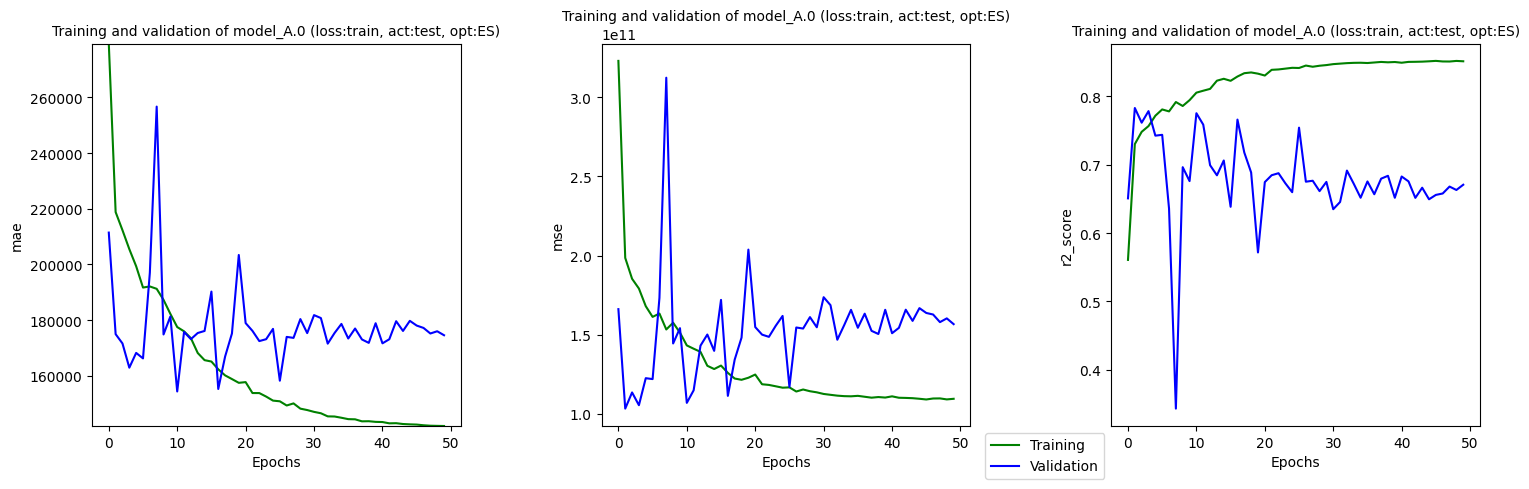

In [17]:
plot_metrics(history_es, height = 1, width = 3, fig_name = "B.train_val_es", save = True)

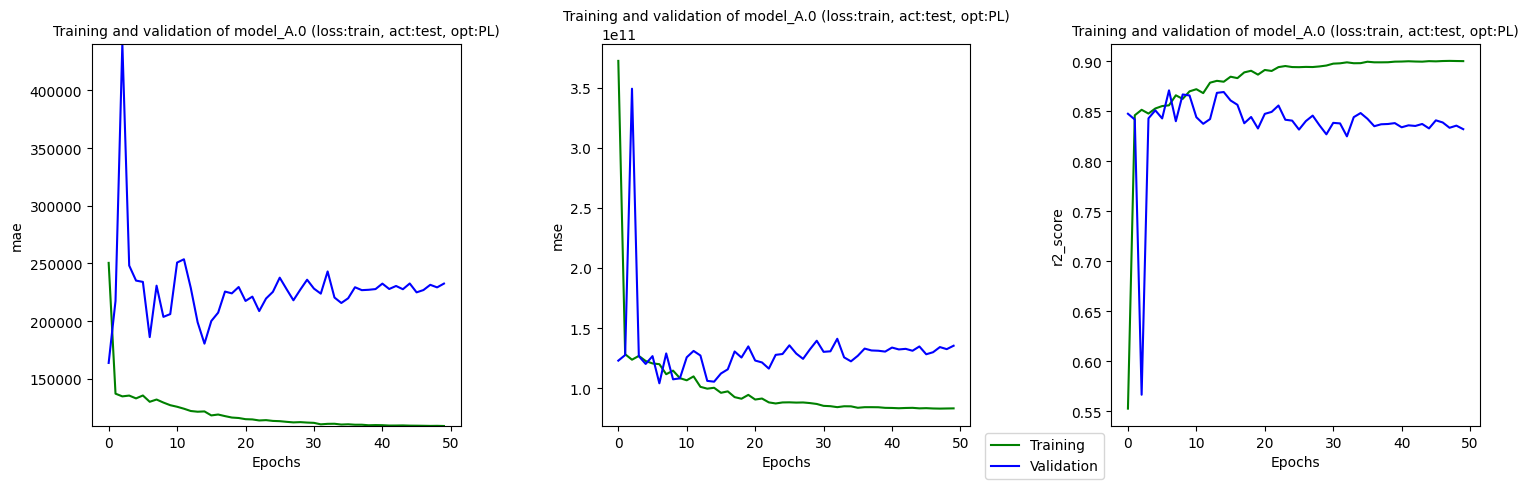

In [18]:
plot_metrics(history_pl, height = 1, width = 3, fig_name = "B.train_val_pl", save = True)

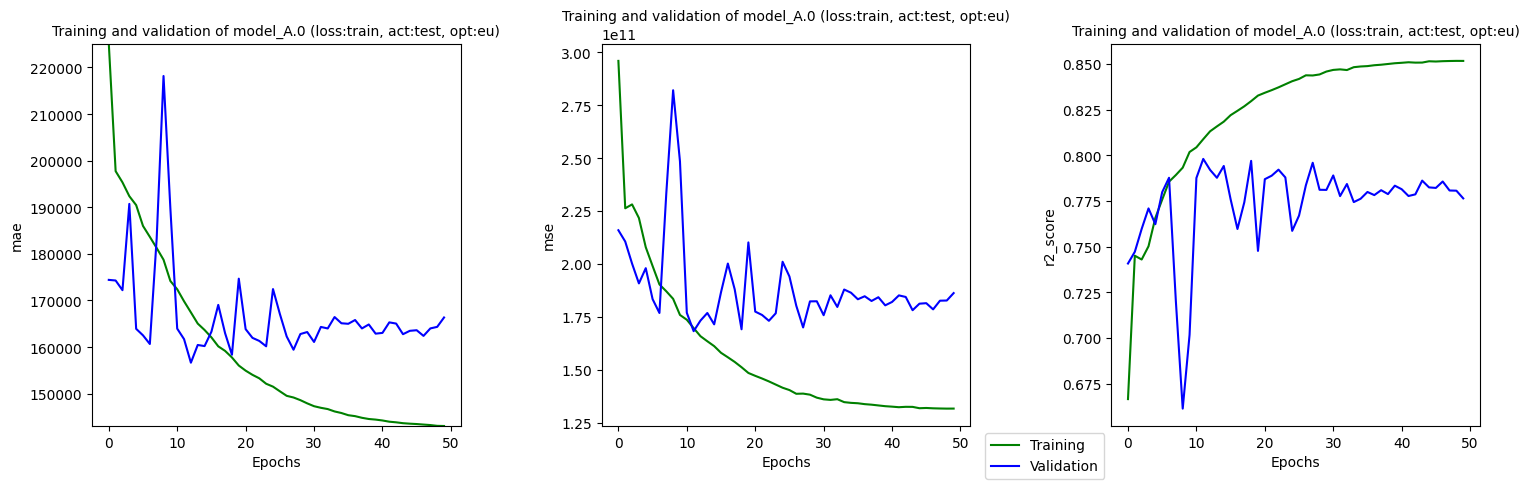

In [19]:
plot_metrics(history_eu, height = 1, width = 3, fig_name = "B.train_val_eu_model_C", save = True)

--------------------------------------------------
EVALUATE MODELS
--------------------------------------------------
--------------------------------------------------

In [20]:
def RAE(y_true, y_pred):
    mean_true = sum(y_true) / len(y_true)
    delta_pred = sum(abs(true_value - pred_value) for true_value, pred_value in zip(y_true, y_pred))
    delta_mean = sum(abs(true_value - mean_true) for true_value in y_true)
    rae = float((delta_pred / delta_mean).item())
    return rae

In [21]:
def RMSE(y_true, y_pred):
    mean_true = sum(y_true) / len(y_true)
    delta_pred = sum((true_value - pred_value)**2 for true_value, pred_value in zip(y_true, y_pred))
    delta_mean = sum(abs(true_value - mean_true)**2 for true_value in y_true)
    rmse = float((delta_pred / delta_mean).item())
    return rmse

In [26]:
def get_test_results(y_test, X_test, model_name, path):
    #LOAD BEST MODELS AND MAKE PREDICTIONS
    model = tf.keras.models.load_model(path)
    #determine metrics
    y_pred = model.predict(X_test, verbose = 0)
    mae_test = mean_absolute_error(y_test, y_pred)
    mse_test = mean_squared_error(y_test, y_pred)
    rae_test = RAE(y_test, y_pred)
    rmse_test = RMSE(y_test, y_pred)
    
    r2_metric = tf.keras.metrics.R2Score()
    r2_metric.update_state(y_test.reshape(-1, 1), y_pred)
    r2_result = r2_metric.result()
    r2_result = r2_result.numpy()

    model_results = {"mae_test": mae_test, 
                      "mse_test": mse_test, 
                      "r2_results": r2_result, 
                      "rae_test": rae_test,
                      "rmse_test": rmse_test}
        
    with open(f"../5.results/B.structured_data/test_results_{model_name}.pickle", "wb") as f:
        pickle.dump(model_results, f)
       
    return model_results

In [27]:
directory = "../4.Models/B.structured.data/"
model_paths = [f"../4.Models/B.structured.data/{model}" for model in os.listdir(directory)]
model_paths

['../4.Models/B.structured.data/ES_model_num_cat_model',
 '../4.Models/B.structured.data/eu_model_num_cat_model',
 '../4.Models/B.structured.data/PL_model_num_cat_model']

In [29]:
#get test results
model_results_es = get_test_results(y_test_es, X_test_es, "es", "../4.Models/B.structured.data/ES_model_num_cat_model/")
model_results_pl = get_test_results(y_test_pl, X_test_pl, "pl", "../4.Models/B.structured.data/PL_model_num_cat_model/")

#spanish on polish set and polish on spanish set
#model_results_es_pl_test = get_test_results(y_test_pl, X_test_pl, "pl", "../4.Models/B.structured.data/ES_model_num_cat_model/")
#model_results_pl_es_test = get_test_results(y_test_es, X_test_es, "pl", "../4.Models/B.structured.data/PL_model_num_cat_model/")
model_results_eu = get_test_results(y_test, X_test, "eu", "../4.Models/B.structured.data/eu_model_num_cat_model/")


total_results = {"model_results_es": model_results_es,
                 "model_results_pl": model_results_pl,
                 "model_results_eu": model_results_eu}
                 #"model_results_es_pl_test": model_results_es_pl_test,
                 #"model_results_pl_es_test": model_results_pl_es_test}

In [30]:
total_results

{'model_results_es': {'mae_test': 186587.62420004353,
  'mse_test': 184704996707.39148,
  'r2_results': 0.6985744,
  'rae_test': 0.38112974166870117,
  'rmse_test': 0.3014254570007324},
 'model_results_pl': {'mae_test': 235444.30303489888,
  'mse_test': 155041059448.6652,
  'r2_results': 0.80678004,
  'rae_test': 0.42073163390159607,
  'rmse_test': 0.19321990013122559},
 'model_results_eu': {'mae_test': 174230.19549504446,
  'mse_test': 202416436926.27527,
  'r2_results': 0.7383336,
  'rae_test': 0.3115482032299042,
  'rmse_test': 0.26166513562202454}}

In [31]:
df_results = pd.DataFrame(total_results).T
df_results

,mae_test,mse_test,r2_results,rae_test,rmse_test
model_results_es,186587.624200,1.847050e+11,0.698574,0.381130,0.301425
model_results_pl,235444.303035,1.550411e+11,0.806780,0.420732,0.193220
model_results_eu,174230.195495,2.024164e+11,0.738334,0.311548,0.261665


In [67]:
#ENCODE COLUMNS
base_n_encoder_cols = ["CPV", "DT_AWARD", "TAL_LOCATION_NUTS"]
one_hot_cols = ["TYPE_OF_CONTRACT", "TOP_TYPE", "B_ACCELERATED"]
X_train, y_train, X_val, y_val, X_test, y_test = encode_scale_split(df.drop(columns = ["ISO_COUNTRY_CODE"]), 0.6, 0.2, 
                                                                    one_hot_cols = one_hot_cols, 
                                                                    base_n_encoder_cols=base_n_encoder_cols,
                                                                    numeric_cols=numeric_cols)

history_eu = B_create_train_model("eu_model_no_countries",
                                    input_dimension = X_train.shape[1], 
                                    X_train = X_train,
                                    y_train = y_train,
                                    X_val = X_val,
                                    y_val = y_val,
                                    epochs = 50,
                                    initial_lr = 0.05, 
                                    batch_size = 16)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 39)]              0         
                                                                 
 dense_12 (Dense)            (None, 64)                2560      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 64)                2112      
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6817 (26.63 KB)
Trainable params: 6817 (26.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
1449/1468 [===

INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 4s 3ms/step - loss: 226539.8281 - mae: 226539.8281 - mse: 291335602176.0000 - r2_score: 0.6717 - val_loss: 182878.8125 - val_mae: 182878.8125 - val_mse: 194389786624.0000 - val_r2_score: 0.7666 - lr: 0.0500
Epoch 2/50
1445/1468 [============================>.] - ETA: 0s - loss: 204650.3438 - mae: 204650.3438 - mse: 245541076992.0000 - r2_score: 0.7225INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 4s 2ms/step - loss: 204644.0625 - mae: 204644.0625 - mse: 244980006912.0000 - r2_score: 0.7239 - val_loss: 185241.9062 - val_mae: 185241.9062 - val_mse: 193007927296.0000 - val_r2_score: 0.7682 - lr: 0.0500
Epoch 3/50
1453/1468 [============================>.] - ETA: 0s - loss: 202070.5469 - mae: 202070.5469 - mse: 240487448576.0000 - r2_score: 0.7290INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 202090.2188 - mae: 202090.2188 - mse: 239621570560.0000 - r2_score: 0.7300 - val_loss: 197704.7656 - val_mae: 197704.7656 - val_mse: 238808317952.0000 - val_r2_score: 0.7132 - lr: 0.0500
Epoch 4/50
1467/1468 [============================>.] - ETA: 0s - loss: 200450.3750 - mae: 200450.3750 - mse: 236333121536.0000 - r2_score: 0.7337INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 200375.7812 - mae: 200375.7812 - mse: 236205686784.0000 - r2_score: 0.7338 - val_loss: 222027.8125 - val_mae: 222027.8125 - val_mse: 300324454400.0000 - val_r2_score: 0.6394 - lr: 0.0500
Epoch 5/50
1468/1468 [==============================] - 3s 2ms/step - loss: 200673.4062 - mae: 200673.4062 - mse: 234326261760.0000 - r2_score: 0.7359 - val_loss: 169395.0469 - val_mae: 169395.0469 - val_mse: 196909481984.0000 - val_r2_score: 0.7635 - lr: 0.0500
Epoch 6/50
1466/1468 [============================>.] - ETA: 0s - loss: 196554.3750 - mae: 196554.3750 - mse: 224056737792.0000 - r2_score: 0.7476INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 196661.9375 - mae: 196661.9375 - mse: 224509100032.0000 - r2_score: 0.7470 - val_loss: 181878.2969 - val_mae: 181878.2969 - val_mse: 251992457216.0000 - val_r2_score: 0.6974 - lr: 0.0500
Epoch 7/50
1452/1468 [============================>.] - ETA: 0s - loss: 194277.5938 - mae: 194277.5938 - mse: 220364963840.0000 - r2_score: 0.7519INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 194421.3906 - mae: 194421.3906 - mse: 220582477824.0000 - r2_score: 0.7514 - val_loss: 189713.2812 - val_mae: 189713.2812 - val_mse: 224169164800.0000 - val_r2_score: 0.7308 - lr: 0.0500
Epoch 8/50
1443/1468 [============================>.] - ETA: 0s - loss: 191437.6875 - mae: 191437.6875 - mse: 212728037376.0000 - r2_score: 0.7605INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 192106.8906 - mae: 192106.8906 - mse: 214845046784.0000 - r2_score: 0.7579 - val_loss: 176772.9531 - val_mae: 176772.9531 - val_mse: 233262153728.0000 - val_r2_score: 0.7199 - lr: 0.0500
Epoch 9/50
1435/1468 [============================>.] - ETA: 0s - loss: 190695.1562 - mae: 190695.1562 - mse: 209148510208.0000 - r2_score: 0.7651INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 190274.3750 - mae: 190274.3750 - mse: 207988015104.0000 - r2_score: 0.7656 - val_loss: 172950.1250 - val_mae: 172950.1250 - val_mse: 202895998976.0000 - val_r2_score: 0.7564 - lr: 0.0452
Epoch 10/50
1467/1468 [============================>.] - ETA: 0s - loss: 187797.4219 - mae: 187797.4219 - mse: 206614773760.0000 - r2_score: 0.7672INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 188009.6719 - mae: 188009.6719 - mse: 207174877184.0000 - r2_score: 0.7665 - val_loss: 181599.2188 - val_mae: 181599.2188 - val_mse: 192593920000.0000 - val_r2_score: 0.7687 - lr: 0.0409
Epoch 11/50
1459/1468 [============================>.] - ETA: 0s - loss: 187133.4844 - mae: 187133.4844 - mse: 207369764864.0000 - r2_score: 0.7667INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 187009.6250 - mae: 187009.6250 - mse: 206924775424.0000 - r2_score: 0.7668 - val_loss: 168394.4844 - val_mae: 168394.4844 - val_mse: 201811705856.0000 - val_r2_score: 0.7577 - lr: 0.0370
Epoch 12/50
1447/1468 [============================>.] - ETA: 0s - loss: 185631.5156 - mae: 185631.5156 - mse: 207360638976.0000 - r2_score: 0.7673INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 185488.0625 - mae: 185488.0625 - mse: 207161622528.0000 - r2_score: 0.7665 - val_loss: 180185.4062 - val_mae: 180185.4062 - val_mse: 218348503040.0000 - val_r2_score: 0.7378 - lr: 0.0335
Epoch 13/50
1466/1468 [============================>.] - ETA: 0s - loss: 183541.3281 - mae: 183541.3281 - mse: 202821451776.0000 - r2_score: 0.7716INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 183514.2969 - mae: 183514.2969 - mse: 202662150144.0000 - r2_score: 0.7716 - val_loss: 167445.3281 - val_mae: 167445.3281 - val_mse: 200411267072.0000 - val_r2_score: 0.7593 - lr: 0.0303
Epoch 14/50
1462/1468 [============================>.] - ETA: 0s - loss: 181636.0781 - mae: 181636.0781 - mse: 198908887040.0000 - r2_score: 0.7753INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 181841.1406 - mae: 181841.1406 - mse: 199342817280.0000 - r2_score: 0.7753 - val_loss: 167633.3750 - val_mae: 167633.3750 - val_mse: 209672749056.0000 - val_r2_score: 0.7482 - lr: 0.0274
Epoch 15/50
1450/1468 [============================>.] - ETA: 0s - loss: 179766.8438 - mae: 179766.8438 - mse: 194720563200.0000 - r2_score: 0.7813INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 179892.1719 - mae: 179892.1719 - mse: 195480059904.0000 - r2_score: 0.7797 - val_loss: 176165.0469 - val_mae: 176165.0469 - val_mse: 229082660864.0000 - val_r2_score: 0.7249 - lr: 0.0248
Epoch 16/50
1465/1468 [============================>.] - ETA: 0s - loss: 178734.9844 - mae: 178734.9844 - mse: 194078736384.0000 - r2_score: 0.7813INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 178615.5625 - mae: 178615.5625 - mse: 193771765760.0000 - r2_score: 0.7816 - val_loss: 166988.3438 - val_mae: 166988.3438 - val_mse: 206067286016.0000 - val_r2_score: 0.7525 - lr: 0.0225
Epoch 17/50
1447/1468 [============================>.] - ETA: 0s - loss: 177177.4375 - mae: 177177.4375 - mse: 188654338048.0000 - r2_score: 0.7873INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 177075.0000 - mae: 177075.0000 - mse: 188406169600.0000 - r2_score: 0.7877 - val_loss: 164028.5625 - val_mae: 164028.5625 - val_mse: 187576729600.0000 - val_r2_score: 0.7747 - lr: 0.0203
Epoch 18/50
1453/1468 [============================>.] - ETA: 0s - loss: 175150.7031 - mae: 175150.7031 - mse: 185264603136.0000 - r2_score: 0.7908INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 175474.9062 - mae: 175474.9062 - mse: 186287538176.0000 - r2_score: 0.7901 - val_loss: 171655.2500 - val_mae: 171655.2500 - val_mse: 219887157248.0000 - val_r2_score: 0.7359 - lr: 0.0184
Epoch 19/50
1451/1468 [============================>.] - ETA: 0s - loss: 174519.1562 - mae: 174519.1562 - mse: 183078584320.0000 - r2_score: 0.7934INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 174532.7344 - mae: 174532.7344 - mse: 183107256320.0000 - r2_score: 0.7936 - val_loss: 166222.9219 - val_mae: 166222.9219 - val_mse: 205436715008.0000 - val_r2_score: 0.7533 - lr: 0.0166
Epoch 20/50
1450/1468 [============================>.] - ETA: 0s - loss: 172962.5625 - mae: 172962.5625 - mse: 181354364928.0000 - r2_score: 0.7957INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 172582.7344 - mae: 172582.7344 - mse: 180592132096.0000 - r2_score: 0.7965 - val_loss: 178236.5938 - val_mae: 178236.5938 - val_mse: 225783382016.0000 - val_r2_score: 0.7289 - lr: 0.0151
Epoch 21/50
1453/1468 [============================>.] - ETA: 0s - loss: 171721.9062 - mae: 171721.9062 - mse: 179253002240.0000 - r2_score: 0.7980INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 171638.8750 - mae: 171638.8750 - mse: 178964955136.0000 - r2_score: 0.7983 - val_loss: 170295.9844 - val_mae: 170295.9844 - val_mse: 216697307136.0000 - val_r2_score: 0.7398 - lr: 0.0136
Epoch 22/50
1439/1468 [============================>.] - ETA: 0s - loss: 169871.0156 - mae: 169871.0156 - mse: 175498018816.0000 - r2_score: 0.8023INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 169648.6719 - mae: 169648.6719 - mse: 175225421824.0000 - r2_score: 0.8025 - val_loss: 169353.7344 - val_mae: 169353.7344 - val_mse: 215226662912.0000 - val_r2_score: 0.7415 - lr: 0.0123
Epoch 23/50
1460/1468 [============================>.] - ETA: 0s - loss: 168689.1719 - mae: 168689.1719 - mse: 172199264256.0000 - r2_score: 0.8063INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 168680.7812 - mae: 168680.7812 - mse: 172225675264.0000 - r2_score: 0.8059 - val_loss: 170914.0938 - val_mae: 170914.0938 - val_mse: 204626051072.0000 - val_r2_score: 0.7543 - lr: 0.0112
Epoch 24/50
1443/1468 [============================>.] - ETA: 0s - loss: 167952.9688 - mae: 167952.9688 - mse: 171182407680.0000 - r2_score: 0.8070INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 167824.8125 - mae: 167824.8125 - mse: 170578034688.0000 - r2_score: 0.8078 - val_loss: 165278.0156 - val_mae: 165278.0156 - val_mse: 192154976256.0000 - val_r2_score: 0.7693 - lr: 0.0101
Epoch 25/50
1438/1468 [============================>.] - ETA: 0s - loss: 166535.1406 - mae: 166535.1406 - mse: 168508899328.0000 - r2_score: 0.8096INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 166736.6875 - mae: 166736.6875 - mse: 168757362688.0000 - r2_score: 0.8098 - val_loss: 163501.2188 - val_mae: 163501.2188 - val_mse: 186813005824.0000 - val_r2_score: 0.7757 - lr: 0.0091
Epoch 26/50
1440/1468 [============================>.] - ETA: 0s - loss: 167008.1406 - mae: 167008.1406 - mse: 168667021312.0000 - r2_score: 0.8104INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 166371.9688 - mae: 166371.9688 - mse: 167304757248.0000 - r2_score: 0.8115 - val_loss: 167131.4531 - val_mae: 167131.4531 - val_mse: 198398181376.0000 - val_r2_score: 0.7618 - lr: 0.0083
Epoch 27/50
1458/1468 [============================>.] - ETA: 0s - loss: 164813.5312 - mae: 164813.5312 - mse: 166141919232.0000 - r2_score: 0.8128INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 165044.6250 - mae: 165044.6250 - mse: 166459572224.0000 - r2_score: 0.8124 - val_loss: 163689.2969 - val_mae: 163689.2969 - val_mse: 185585090560.0000 - val_r2_score: 0.7771 - lr: 0.0075
Epoch 28/50
1463/1468 [============================>.] - ETA: 0s - loss: 164663.7812 - mae: 164663.7812 - mse: 165138759680.0000 - r2_score: 0.8141INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 164477.6250 - mae: 164477.6250 - mse: 164788469760.0000 - r2_score: 0.8143 - val_loss: 165684.8125 - val_mae: 165684.8125 - val_mse: 194652602368.0000 - val_r2_score: 0.7663 - lr: 0.0068
Epoch 29/50
1465/1468 [============================>.] - ETA: 0s - loss: 163540.0469 - mae: 163540.0469 - mse: 164049289216.0000 - r2_score: 0.8152INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 163402.6719 - mae: 163402.6719 - mse: 163818340352.0000 - r2_score: 0.8154 - val_loss: 165825.5625 - val_mae: 165825.5625 - val_mse: 199393509376.0000 - val_r2_score: 0.7606 - lr: 0.0061
Epoch 30/50
1461/1468 [============================>.] - ETA: 0s - loss: 162823.7656 - mae: 162823.7656 - mse: 163075407872.0000 - r2_score: 0.8163INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 162643.7031 - mae: 162643.7031 - mse: 162673229824.0000 - r2_score: 0.8167 - val_loss: 170548.6875 - val_mae: 170548.6875 - val_mse: 203988467712.0000 - val_r2_score: 0.7550 - lr: 0.0055
Epoch 31/50
1450/1468 [============================>.] - ETA: 0s - loss: 162510.3281 - mae: 162510.3281 - mse: 162012823552.0000 - r2_score: 0.8173INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 162408.3125 - mae: 162408.3125 - mse: 161822326784.0000 - r2_score: 0.8176 - val_loss: 168100.6406 - val_mae: 168100.6406 - val_mse: 202102882304.0000 - val_r2_score: 0.7573 - lr: 0.0050
Epoch 32/50
1463/1468 [============================>.] - ETA: 0s - loss: 161116.6875 - mae: 161116.6875 - mse: 159657918464.0000 - r2_score: 0.8198INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 161440.5781 - mae: 161440.5781 - mse: 160340377600.0000 - r2_score: 0.8193 - val_loss: 166485.3906 - val_mae: 166485.3906 - val_mse: 197103517696.0000 - val_r2_score: 0.7633 - lr: 0.0045
Epoch 33/50
1439/1468 [============================>.] - ETA: 0s - loss: 161580.8750 - mae: 161580.8750 - mse: 161234894848.0000 - r2_score: 0.8183INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 161220.9375 - mae: 161220.9375 - mse: 160226066432.0000 - r2_score: 0.8194 - val_loss: 167350.3594 - val_mae: 167350.3594 - val_mse: 197753978880.0000 - val_r2_score: 0.7625 - lr: 0.0041
Epoch 34/50
1448/1468 [============================>.] - ETA: 0s - loss: 160589.1094 - mae: 160589.1094 - mse: 157860052992.0000 - r2_score: 0.8217INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 160791.4844 - mae: 160791.4844 - mse: 158449106944.0000 - r2_score: 0.8214 - val_loss: 169246.8594 - val_mae: 169246.8594 - val_mse: 201056714752.0000 - val_r2_score: 0.7586 - lr: 0.0037
Epoch 35/50
1430/1468 [============================>.] - ETA: 0s - loss: 160168.3750 - mae: 160168.3750 - mse: 158124949504.0000 - r2_score: 0.8209INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 160304.5469 - mae: 160304.5469 - mse: 158809751552.0000 - r2_score: 0.8210 - val_loss: 167403.8438 - val_mae: 167403.8438 - val_mse: 199400865792.0000 - val_r2_score: 0.7605 - lr: 0.0034
Epoch 36/50
1464/1468 [============================>.] - ETA: 0s - loss: 159849.3906 - mae: 159849.3906 - mse: 158155538432.0000 - r2_score: 0.8215INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 159916.8438 - mae: 159916.8438 - mse: 158181883904.0000 - r2_score: 0.8217 - val_loss: 165567.1875 - val_mae: 165567.1875 - val_mse: 191590711296.0000 - val_r2_score: 0.7699 - lr: 0.0030
Epoch 37/50
1462/1468 [============================>.] - ETA: 0s - loss: 159551.4688 - mae: 159551.4688 - mse: 156784099328.0000 - r2_score: 0.8229INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 159762.3438 - mae: 159762.3438 - mse: 157527146496.0000 - r2_score: 0.8225 - val_loss: 166981.3750 - val_mae: 166981.3750 - val_mse: 195997040640.0000 - val_r2_score: 0.7646 - lr: 0.0028
Epoch 38/50
1431/1468 [============================>.] - ETA: 0s - loss: 159014.1562 - mae: 159014.1562 - mse: 156686188544.0000 - r2_score: 0.8235INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 159200.7188 - mae: 159200.7188 - mse: 156625141760.0000 - r2_score: 0.8235 - val_loss: 165900.5312 - val_mae: 165900.5312 - val_mse: 193501642752.0000 - val_r2_score: 0.7676 - lr: 0.0025
Epoch 39/50
1431/1468 [============================>.] - ETA: 0s - loss: 159119.2812 - mae: 159119.2812 - mse: 156330983424.0000 - r2_score: 0.8240INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 158938.4219 - mae: 158938.4219 - mse: 157066625024.0000 - r2_score: 0.8230 - val_loss: 167340.7344 - val_mae: 167340.7344 - val_mse: 198059425792.0000 - val_r2_score: 0.7622 - lr: 0.0023
Epoch 40/50
1446/1468 [============================>.] - ETA: 0s - loss: 158791.3750 - mae: 158791.3750 - mse: 156201385984.0000 - r2_score: 0.8241INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 158703.4062 - mae: 158703.4062 - mse: 155775336448.0000 - r2_score: 0.8244 - val_loss: 165905.1094 - val_mae: 165905.1094 - val_mse: 194638315520.0000 - val_r2_score: 0.7663 - lr: 0.0020
Epoch 41/50
1457/1468 [============================>.] - ETA: 0s - loss: 158305.1250 - mae: 158305.1250 - mse: 155329216512.0000 - r2_score: 0.8249INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 4s 3ms/step - loss: 158417.3125 - mae: 158417.3125 - mse: 155239448576.0000 - r2_score: 0.8250 - val_loss: 169132.1562 - val_mae: 169132.1562 - val_mse: 199362396160.0000 - val_r2_score: 0.7606 - lr: 0.0018
Epoch 42/50
1466/1468 [============================>.] - ETA: 0s - loss: 158464.8125 - mae: 158464.8125 - mse: 155600683008.0000 - r2_score: 0.8247INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 158375.3281 - mae: 158375.3281 - mse: 155442036736.0000 - r2_score: 0.8248 - val_loss: 166130.4062 - val_mae: 166130.4062 - val_mse: 193256161280.0000 - val_r2_score: 0.7679 - lr: 0.0017
Epoch 43/50
1438/1468 [============================>.] - ETA: 0s - loss: 158415.3594 - mae: 158415.3594 - mse: 156336963584.0000 - r2_score: 0.8239INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 158113.6250 - mae: 158113.6250 - mse: 155358363648.0000 - r2_score: 0.8249 - val_loss: 167785.9062 - val_mae: 167785.9062 - val_mse: 195054370816.0000 - val_r2_score: 0.7658 - lr: 0.0015
Epoch 44/50
1464/1468 [============================>.] - ETA: 0s - loss: 157820.6406 - mae: 157820.6406 - mse: 155417214976.0000 - r2_score: 0.8251INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 157939.1406 - mae: 157939.1406 - mse: 155331346432.0000 - r2_score: 0.8249 - val_loss: 167782.0000 - val_mae: 167782.0000 - val_mse: 199208583168.0000 - val_r2_score: 0.7608 - lr: 0.0014
Epoch 45/50
1456/1468 [============================>.] - ETA: 0s - loss: 157554.6719 - mae: 157554.6719 - mse: 154014531584.0000 - r2_score: 0.8266INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 157751.2812 - mae: 157751.2812 - mse: 154494599168.0000 - r2_score: 0.8259 - val_loss: 166727.0312 - val_mae: 166727.0312 - val_mse: 195360096256.0000 - val_r2_score: 0.7654 - lr: 0.0012
Epoch 46/50
1447/1468 [============================>.] - ETA: 0s - loss: 157338.5156 - mae: 157338.5156 - mse: 153696370688.0000 - r2_score: 0.8257INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 157560.9062 - mae: 157560.9062 - mse: 154315177984.0000 - r2_score: 0.8261 - val_loss: 167655.2500 - val_mae: 167655.2500 - val_mse: 199884226560.0000 - val_r2_score: 0.7600 - lr: 0.0011
Epoch 47/50
1457/1468 [============================>.] - ETA: 0s - loss: 157540.0156 - mae: 157540.0156 - mse: 154728660992.0000 - r2_score: 0.8260INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 157407.8750 - mae: 157407.8750 - mse: 154282688512.0000 - r2_score: 0.8261 - val_loss: 168757.2969 - val_mae: 168757.2969 - val_mse: 199391723520.0000 - val_r2_score: 0.7606 - lr: 0.0010
Epoch 48/50
1461/1468 [============================>.] - ETA: 0s - loss: 157227.9844 - mae: 157227.9844 - mse: 153428131840.0000 - r2_score: 0.8273INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 157337.9531 - mae: 157337.9531 - mse: 153962758144.0000 - r2_score: 0.8265 - val_loss: 168726.1406 - val_mae: 168726.1406 - val_mse: 199965589504.0000 - val_r2_score: 0.7599 - lr: 9.1578e-04
Epoch 49/50
1444/1468 [============================>.] - ETA: 0s - loss: 157205.7500 - mae: 157205.7500 - mse: 153744179200.0000 - r2_score: 0.8266INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 157282.5625 - mae: 157282.5625 - mse: 154343260160.0000 - r2_score: 0.8261 - val_loss: 167561.5938 - val_mae: 167561.5938 - val_mse: 195483615232.0000 - val_r2_score: 0.7653 - lr: 8.2863e-04
Epoch 50/50
1460/1468 [============================>.] - ETA: 0s - loss: 157418.6562 - mae: 157418.6562 - mse: 154399555584.0000 - r2_score: 0.8262INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


INFO:tensorflow:Assets written to: ../4.Models/B.structured.data\eu_model_no_countries_num_cat_model\assets


1468/1468 [==============================] - 3s 2ms/step - loss: 157148.9531 - mae: 157148.9531 - mse: 153760727040.0000 - r2_score: 0.8267 - val_loss: 167803.1562 - val_mae: 167803.1562 - val_mse: 198107693056.0000 - val_r2_score: 0.7621 - lr: 7.4978e-04
